# **Covid-19 Vaccines - Sentiment Analysis & Time Series**
Notebook for the second project for the Machine Learning Complements course (CAC).

## **Introduction**


## Imports

The following libraries will be used in this project:

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
import warnings
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.classify import NaiveBayesClassifier
nltk.download('vader_lexicon')
warnings.simplefilter(action='ignore')


[nltk_data] Downloading package wordnet to /home/oliveira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oliveira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/oliveira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/oliveira/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load Data

In [2]:
df_tweets = pd.read_csv('tweets.csv')

## Initial Observations

The dataset contains a single file: `tweets.csv`.

In this section we will take a look at the first few rows of each file to get a better understanding of the data, and do some initial data exploration.

In [3]:
ut.initial_obs(df_tweets)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False



Attributes: ['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']
Entries: 228207
Attribute Count: 16

----Null Count----
id                      0
user_name               2
user_location       66911
user_description    17023
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            49703
source                119
retweets                0
favorites               0
is_retweet              0
dtype: int64


## Data Understanding

## Data Pre-Processing
We can see that many attributes are not really relevant for the kind of work we will be doing. Therefore, we'll just selec tthe most relevant ones.

In [4]:
df_tweets = df_tweets[['id','user_location','date','text','hashtags']]
pd.set_option('display.max_colwidth', None)

df_tweets['text'].head(5)

0                                               Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
2    #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3    Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
4         Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq
Name: text, dtype: object

### Removing Spaces within the text
When removing spaces within the text, ensure seamless integration of words for enhanced readability and processing efficiency.

In [5]:
df_tweets['text'] = df_tweets['text'].apply(ut.trim_text)
df_tweets['text'].head(5)

0                                               Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
2    #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3    Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
4         Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq
Name: text, dtype: object

### Contractions Mapping
Contractions mapping simplifies language by expanding contractions like "can't" to "cannot" for consistent analysis and interpretation.

In [6]:
df_tweets['text'] = df_tweets['text'].apply(contractions.fix)
df_tweets['text'].head(5)

0                                                 Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we have ev… https://t.co/dlCHrZjkhm
2      #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3     Facts are immutable, Senator, even when you are not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
4           Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq
Name: text, dtype: object

### Cleaning HTML
Cleaning HTML tags from text data streamlines content for NLP tasks, preventing interference from markup elements.

In [7]:
df_tweets['text'] = df_tweets['text'].apply(lambda x:re.sub(r"http\S+", "", x))
df_tweets['text'].head(5)

0                                                 Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech 
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we have ev… 
2      #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… 
3     Facts are immutable, Senator, even when you are not ethically sturdy enough to acknowledge them. (1) You were born i… 
4           Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… 
Name: text, dtype: object

### Emojis & Emotion Handling
Emojis and emotion handling enrich text analysis by capturing nuances of sentiment and expression for deeper understanding. We thought about removing them initially, however their presence may be crucial to identify sentiments within the text.

In [8]:
pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251\U0001F004\U0001F0CF\U0001F170-\U0001F251\U0001F600-\U0001F64F\U0001F680-\U0001F6FF]+', flags=re.UNICODE)

# Find examples in df_tweets['text'] that have emojis
emojis_examples = df_tweets[df_tweets['text'].str.contains(pattern, na=False)][0:5]

for index in emojis_examples.index:
    print(df_tweets.loc[index, 'text'])

df_tweets['text'] = df_tweets['text'].apply(ut.convert_emojis_to_text)

print('\n')

for index in emojis_examples.index:
    emoji_text = df_tweets.loc[index, 'text']
    print(emoji_text)

💉 #Vaccine #TrumpVaccine #AstraZeneca #PfizerBioNTech #Pfizervaccine #PfizerCovidVaccine #Pfizer's COVID-19 belong… 
@ZubyMusic 6 deaths so far. It is only death, nothing to worry about then 🤔 #CovidVaccines #Pfizervaccine… 
Ladies and Gentlemen, now we have #CovidVaccine experts in each and every household of #Pakistan #PfizerBioNTech #oxfordvaccine 🤦‍♂️
When The #CovidVaccine Poisons Enough Of The LEFT With "Side Effects" Like #BellsPalsy Or ☠️ As They Are Flocking… 
I have never been so excited to get a vaccine 💉💉💉 #CovidVaccine #PfizerBioNTech #VaccinesSaveLives #VaccinesWork 


syringe #Vaccine #TrumpVaccine #AstraZeneca #PfizerBioNTech #Pfizervaccine #PfizerCovidVaccine #Pfizer's COVID-19 belong… 
@ZubyMusic 6 deaths so far. It is only death, nothing to worry about then thinking face #CovidVaccines #Pfizervaccine… 
Ladies and Gentlemen, now we have #CovidVaccine experts in each and every household of #Pakistan #PfizerBioNTech #oxfordvaccine man facepalming
When The #CovidVaccine 

### Handling Twitter Handles (@) & Hashtags
Handling Twitter handles (@) and hashtags facilitates contextual analysis and topic extraction in social media text. We removed the twitter handle, as they mostly are used to identify persons therefore they are not very important in this matter. On the other hand, hashtags may indicate sentiments or other important informations like topics. e.g #sad, #happy or #astrozeneca

In [9]:
df_tweets['text'] = df_tweets['text'].apply(ut.remove_twitter_handles_hashtags)

for index in emojis_examples.index:
    emoji_text = df_tweets.loc[index, 'text']
    print(emoji_text)

syringe Vaccine TrumpVaccine AstraZeneca PfizerBioNTech Pfizervaccine PfizerCovidVaccine Pfizer's COVID-19 belong… 
 6 deaths so far. It is only death, nothing to worry about then thinking face CovidVaccines Pfizervaccine… 
Ladies and Gentlemen, now we have CovidVaccine experts in each and every household of Pakistan PfizerBioNTech oxfordvaccine man facepalming
When The CovidVaccine Poisons Enough Of The LEFT With "Side Effects" Like BellsPalsy Or skull and crossbones As They Are Flocking… 
I have never been so excited to get a vaccine syringesyringesyringe CovidVaccine PfizerBioNTech VaccinesSaveLives VaccinesWork 


### Convert text to lower-case
Converting all the characters to lower case so that words in different forms can be interpreted as the same. The problem with this is that in social media people may use upper-case to express sentiments, e.g SAD, HAPPY.

Here we also remove special characters, keeping only characters.

In [10]:
df_tweets['text'] = df_tweets['text'].apply(ut.remove_special_characters)

df_tweets['text'] = df_tweets['text'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
df_tweets['text'] = df_tweets['text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

df_tweets['text'] = df_tweets['text'].str.lower()

### Tokenization
Tokenization breaks down text into individual units, such as words or phrases, enabling granular analysis and feature extraction. We also remove stopwords, meaning words that often appear within the text and don't add any meaning to it.

In [11]:
df_tweets['tokenized_text'] = df_tweets['text'].apply(lambda x: word_tokenize(x))
df_tweets['tokenized_text'] = df_tweets['tokenized_text'].apply(ut.remove_stopwords)

df_tweets['tokenized_text'].head(5)

0                                       [folks, said, daikon, paste, could, treatcytokine, storm, pfizerbiontech]
1                                [world, wrong, side, history, year, hopefully, biggest, vaccination, effort, ev]
2    [coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, created, last, years]
3                                 [facts, immutable, senator, even, ethically, sturdy, enough, acknowledge, born]
4                                                [explain, needvaccine, whereareallthesickpeople, pfizerbiontech]
Name: tokenized_text, dtype: object

### Stemming
Stemming typically chops off prefixes and/or suffixes of words to derive the root form. It's a simpler and faster process compared to lemmatization. However, stemming doesn't always result in valid words. For instance, "running" might be stemmed to "runn," which isn't a valid word.

In [12]:
stemmer = PorterStemmer()
df_tweets['stemmed_text'] = df_tweets['tokenized_text'].apply(lambda x: [stemmer.stem(word) for word in x])

df_tweets['stemmed_text'].head(5)

0                                     [folk, said, daikon, past, could, treatcytokin, storm, pfizerbiontech]
1                                     [world, wrong, side, histori, year, hope, biggest, vaccin, effort, ev]
2    [coronaviru, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccin, creat, last, year]
3                                        [fact, immut, senat, even, ethic, sturdi, enough, acknowledg, born]
4                                             [explain, needvaccin, whereareallthesickpeopl, pfizerbiontech]
Name: stemmed_text, dtype: object

### Lemmatization
Lemmatization, on the other hand, involves resolving words to their dictionary form, known as the lemma. It uses lexical knowledge bases to ensure that the root form returned is a valid word. For example, "am," "are," and "is" would all be lemmatized to "be." Lemmatization is generally more accurate than stemming but can be slower due to its linguistic complexity.

In [13]:
lemmatizer = WordNetLemmatizer()
df_tweets['lemmatized_text'] = df_tweets['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

df_tweets['lemmatized_text'].head(5)

0                                       [folk, said, daikon, paste, could, treatcytokine, storm, pfizerbiontech]
1                               [world, wrong, side, history, year, hopefully, biggest, vaccination, effort, ev]
2    [coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, created, last, year]
3                                 [fact, immutable, senator, even, ethically, sturdy, enough, acknowledge, born]
4                                               [explain, needvaccine, whereareallthesickpeople, pfizerbiontech]
Name: lemmatized_text, dtype: object

## Sentiment Analysis

In [14]:
df_tweets['clean_text'] = df_tweets['lemmatized_text'].apply(lambda text: " ".join(text))

sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    vader_scores = sid.polarity_scores(text)['compound']
    if vader_scores >= 0.05:
        sentiment = 'Positive'
    elif vader_scores <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment, vader_scores

df_tweets['sentiment'], df_tweets['vader_score'] = zip(*df_tweets['clean_text'].apply(analyze_sentiment))

### Positive Sentiment - WordCloud

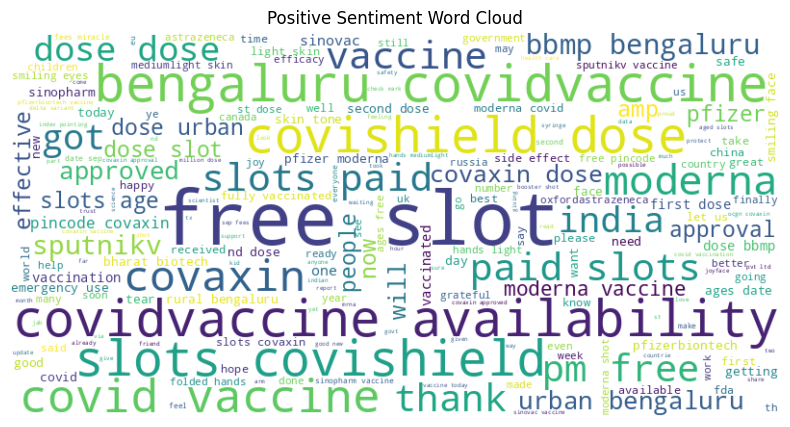

In [17]:
positive_tweets = df_tweets[df_tweets['sentiment'] == 'Positive']
negative_tweets = df_tweets[df_tweets['sentiment'] == 'Negative']

ut.generate_word_cloud(positive_tweets['text'], 'Positive Sentiment Word Cloud')

### Negative Sentiment - WordCloud

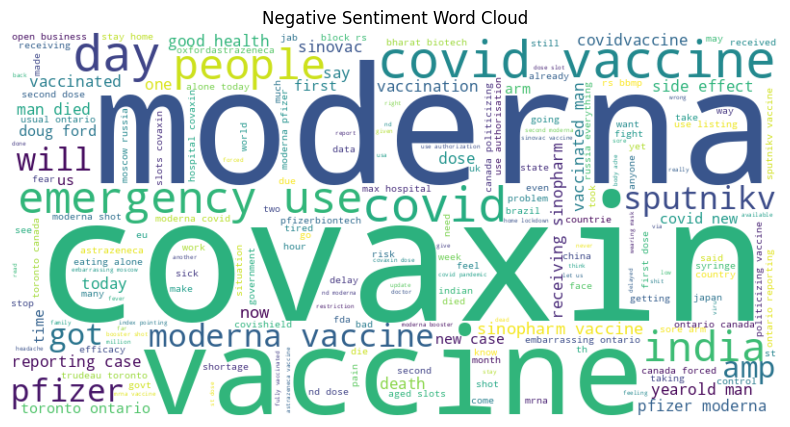

In [18]:
ut.generate_word_cloud(negative_tweets['text'], 'Negative Sentiment Word Cloud')